## Introduction

This notebook is for illustrating the examples we used in our paper, for demonstrating the correctness of our math deduction.  

In [25]:
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(suppress=True)
np.set_printoptions(precision=5)
# np.random.seed(3)

Note that we define a function for creating a simulated O/E matrix and transform it into the Pearson matrix.   

In [26]:
def generate_oe_matrix(length:int, variance_threshold_L:int = 0.85, variance_threshold_U:int = 1):
    """
        Generates a random 5x5 symmetric matrix with positive values and
        the first PC explaining at least L% and at most U% of the variance.
    """

    while True:
        # Create a nxn array with random positive values
        matrix = np.abs(np.random.randn(length, length) * 10)  # Use absolute values for positive entries
        # Make the array symmetric
        matrix = matrix + matrix.T
        origin_matrix = matrix.copy()

        # Subtract the mean of each row to center the data (For PCA)
        matrix = matrix - matrix.mean(axis=1, keepdims=True)

        # SVD 
        n = len(matrix[0])
        y = matrix.T / np.sqrt(n)
        U, S, Vh = np.linalg.svd(y, full_matrices=True)
        eigenvalues = S * S
        EV1_explained_variance = eigenvalues[0] / np.sum(eigenvalues) 

        # Check if the first PC explains at least the desired variance
        if EV1_explained_variance >= variance_threshold_L and EV1_explained_variance < variance_threshold_U:
            return origin_matrix

length = 5
# Generate a simulated O/E matrix.
# oe = generate_oe_matrix(length=length)

from hicpep import peptools

X = peptools.read_pearson(
    pearson="/home/jordan990301/Projects/HiCPEP/test/gm12878_1000000_pearson_chr1.txt"
)

X = X.astype('float64')
diag = np.diag(X)
diag_valid = ~np.isnan(diag)
ixgrid = np.ix_(diag_valid, diag_valid) # Record the position of the valid sub-matrix.
X = X[ixgrid] 

# Calculate the Pearson matrix.
# X = np.corrcoef(oe)
# Subtract the mean of each row to center the data
X = X - X.mean(axis=1, keepdims=True)

#### Perform PCA on the Pearson correlation matrix <br>

In [27]:
n = length
y = X.T / np.sqrt(n)

U, S, Vh = np.linalg.svd(y, full_matrices=True)
eigenvalues = S * S
explained_variance_ratios = eigenvalues / np.sum(eigenvalues)
cov_x = np.matmul(y.T, y)
V_Cx = np.matmul(Vh, cov_x)

print('explained variances (lambda)')
print(eigenvalues, '\n')
print('explained variance ratios')
print(explained_variance_ratios, '\n')
print("X")
print(X, '\n')
print("Cx")
print(cov_x, '\n')
print("V")
print(V_Cx, '\n')
print("P transpose")
print(Vh.T, '\n')

explained variances (lambda)
[2364.44971  195.56536  112.95767   84.65541   29.51506    5.58705
    1.48377    0.99926    0.73835    0.45121    0.40085    0.27801
    0.2535     0.18913    0.17523    0.11549    0.08868    0.07117
    0.05736    0.05248    0.03348    0.03145    0.02826    0.02445
    0.02237    0.01778    0.01506    0.0133     0.01213    0.01072
    0.00985    0.00819    0.00705    0.00665    0.00588    0.0056
    0.00492    0.00454    0.00401    0.00367    0.00331    0.00309
    0.00299    0.00239    0.0023     0.00209    0.00191    0.00166
    0.00158    0.0015     0.00144    0.00126    0.00119    0.00103
    0.00095    0.00091    0.00077    0.00075    0.00074    0.00068
    0.00063    0.00058    0.00055    0.00051    0.00045    0.00043
    0.0004     0.00038    0.00037    0.00033    0.00032    0.0003
    0.0003     0.00026    0.00024    0.00024    0.00024    0.00022
    0.0002     0.00019    0.00018    0.00017    0.00016    0.00016
    0.00015    0.00014    0.00014  

In [28]:
print('V_Cx[0]')
print(V_Cx[0], '\n')
print('Vh[0]')
print(Vh[0], '\n')

V_Cx[0]
[ -56.92885  179.50212  115.09684  106.52781  -10.62829    6.37465
  196.78607  130.53125  186.67048  182.23246  197.66998  208.4119
  193.91808 -100.62743   71.51423  176.60992  179.3328   151.90896
  100.59088  196.00492  185.29008  189.80045  192.29325  196.19129
  175.26799  164.87312  175.69521  156.7218   151.21976  182.23887
  105.526    199.39085  174.87905  197.994     91.1362   190.32286
  192.30318  148.00107  196.45095  183.07428  160.09262  178.20576
  161.99837  187.93844  190.90487  181.37356  170.31542   88.33799
  -77.70894 -154.22969 -164.91683   12.6412   147.53587  176.26209
  169.98041   98.88625 -108.01796 -127.99615 -134.62661   -2.43889
 -190.86428 -190.94245 -120.01106  -85.73382 -162.96302 -166.98432
 -196.48212 -130.96192 -201.8359  -208.97752 -202.61769 -214.28975
 -214.17118 -210.78418 -214.67177 -215.14074 -210.40492 -215.41551
 -153.43781 -208.63252 -209.26074 -209.08928 -211.02846 -200.93045
 -207.39416 -136.20317 -206.05447 -159.74314 -207.87795

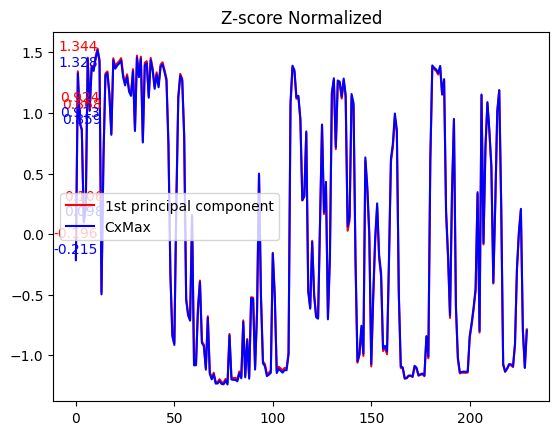

In [29]:
cov_x_sum = [np.sum(np.abs(row)) for row in cov_x]
cov_x_sum = list(enumerate(cov_x_sum)) 
sorted_list = sorted(cov_x_sum, key=lambda x: x[1], reverse=True) 
cov_x_selected = cov_x[sorted_list[0][0]]

if np.corrcoef(cov_x_selected, Vh[0])[0][1] < 0:
    cov_x_selected = -cov_x_selected

Vh0_Norm = (Vh[0] - np.mean(Vh[0])) / np.std(Vh[0])
cov_x_selected_Norm = (cov_x_selected - np.mean(cov_x_selected)) / np.std(cov_x_selected)

plt.plot(Vh0_Norm, c="red")
plt.plot(cov_x_selected_Norm, c="blue")

plt.title("Z-score Normalized")
plt.legend(["1st principal component", "CxMax"])

# zip joins x and y coordinates in pairs
# https://queirozf.com/entries/add-labels-and-text-to-matplotlib-plots-annotation-examples
Vh0_Norm_xs = np.arange(0, length, 1)
for x, y in zip(Vh0_Norm_xs, Vh0_Norm):
    label = "{:.3f}".format(y)
    plt.annotate(
        label, # this is the text
        (x, y), # these are the coordinates to position the label
        textcoords="offset points", # how to position the text
        xytext=(0, 15), # distance from text to points (x,y)
        ha='center', # horizontal alignment can be left, right or center
        color='red'
    ) 

cov_x_selected_Norm_xs = np.arange(0, length, 1)
for x, y in zip(cov_x_selected_Norm_xs, cov_x_selected_Norm):
    label = "{:.3f}".format(y)
    plt.annotate(
        label, # this is the text
        (x, y), # these are the coordinates to position the label
        textcoords="offset points", # how to position the text
        xytext=(0, 5), # distance from text to points (x,y)
        ha='center', # horizontal alignment can be left, right or center
        color='blue'
    ) 

<BarContainer object of 230 artists>

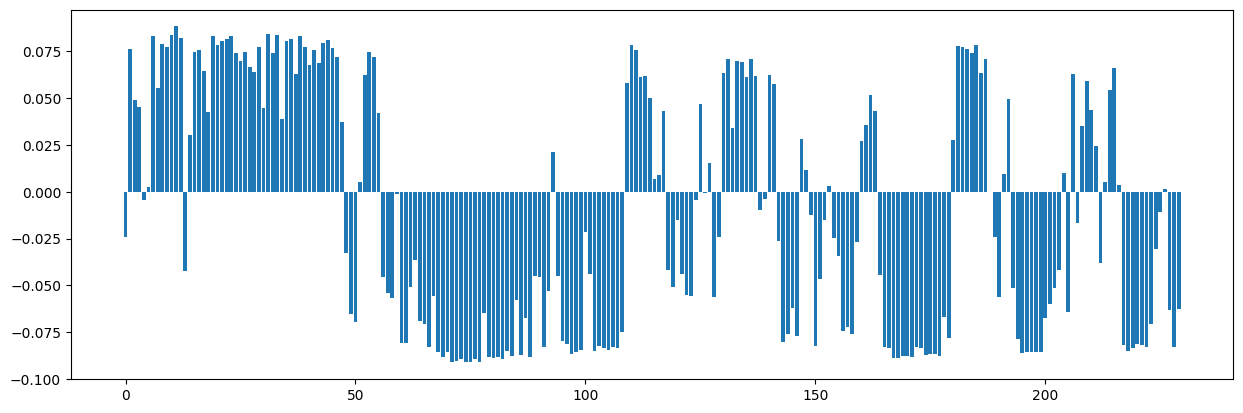

In [30]:
plt.figure().set_figwidth(15)
plt.bar(x=[i for i in range(len(Vh[0]))], height=Vh[0])

In [31]:
plt.close('all')

### Check the plot without Normalization on the Pearson correlation matrix

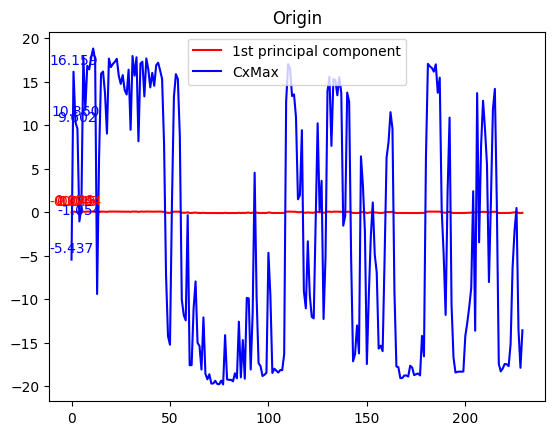

In [32]:
plt.plot(Vh[0], c="red")
plt.plot(cov_x_selected, c="blue")

plt.title("Origin")
plt.legend(["1st principal component", "CxMax"])

# zip joins x and y coordinates in pairs
# https://queirozf.com/entries/add-labels-and-text-to-matplotlib-plots-annotation-examples
Vh0_xs = np.arange(0, length, 1)
for x, y in zip(Vh0_xs, Vh[0]):
    label = "{:.3f}".format(y)
    plt.annotate(
        label, # this is the text
        (x, y), # these are the coordinates to position the label
        textcoords="offset points", # how to position the text
        xytext=(0, 5), # distance from text to points (x,y)
        ha='center', # horizontal alignment can be left, right or center
        color='red'
    ) 

cov_x_selected_xs = np.arange(0, length, 1)
for x, y in zip(cov_x_selected_xs, cov_x_selected):
    label = "{:.3f}".format(y)
    plt.annotate(
        label, # this is the text
        (x, y), # these are the coordinates to position the label
        textcoords="offset points", # how to position the text
        xytext=(0, 5), # distance from text to points (x,y)
        ha='center', # horizontal alignment can be left, right or center
        color='blue'
    ) 

In [33]:
print("The first row of V")
print(V_Cx[0], '\n')
print("Corresponding entry of V:")
print(np.dot(Vh[0], cov_x_selected))

The first row of V
[ -56.92885  179.50212  115.09684  106.52781  -10.62829    6.37465
  196.78607  130.53125  186.67048  182.23246  197.66998  208.4119
  193.91808 -100.62743   71.51423  176.60992  179.3328   151.90896
  100.59088  196.00492  185.29008  189.80045  192.29325  196.19129
  175.26799  164.87312  175.69521  156.7218   151.21976  182.23887
  105.526    199.39085  174.87905  197.994     91.1362   190.32286
  192.30318  148.00107  196.45095  183.07428  160.09262  178.20576
  161.99837  187.93844  190.90487  181.37356  170.31542   88.33799
  -77.70894 -154.22969 -164.91683   12.6412   147.53587  176.26209
  169.98041   98.88625 -108.01796 -127.99615 -134.62661   -2.43889
 -190.86428 -190.94245 -120.01106  -85.73382 -162.96302 -166.98432
 -196.48212 -130.96192 -201.8359  -208.97752 -202.61769 -214.28975
 -214.17118 -210.78418 -214.67177 -215.14074 -210.40492 -215.41551
 -153.43781 -208.63252 -209.26074 -209.08928 -211.02846 -200.93045
 -207.39416 -136.20317 -206.05447 -159.74314

In [34]:
plt.close('all')